# Play with traject_preprocess

In [1]:
import os
import pickle
import random
import time
import numpy as np
import torch

In [2]:
DATASET_NAME_TO_NUM = {
    'eth': 0,
    'hotel': 1,
    'zara1': 2,
    'zara2': 3,
    'univ': 4
}

In [3]:
class Object(object):
    pass

args = Object()
args.dataset = 'eth5'
args.test_set = 'eth'
args.save_dir = './output/' + args.test_set + "/"
if not os.path.exists(args.save_dir):
    os.makedirs(args.save_dir)

self = Object()
self.args = args


## 1. Init: train and test directories

In [4]:
if self.args.dataset == 'eth5':

    self.data_dirs = ['../data/eth/univ', '../data/eth/hotel',
                      '../data/ucy/zara/zara01', '../data/ucy/zara/zara02',
                      '../data/ucy/univ/students001', '../data/ucy/univ/students003',
                      '../data/ucy/univ/uni_examples', '../data/ucy/zara/zara03']

    # Data directory where the pre-processed pickle file resides
    self.data_dir = './data'
    skip = [6, 10, 10, 10, 10, 10, 10, 10]

    train_set = [i for i in range(len(self.data_dirs))]

    assert args.test_set in DATASET_NAME_TO_NUM.keys(), 'Unsupported dataset {}'.format(args.test_set)

    args.test_set = DATASET_NAME_TO_NUM[args.test_set]

    if args.test_set == 4 or args.test_set == 5:
        self.test_set = [4, 5]
    else:
        self.test_set = [self.args.test_set]

    for x in self.test_set:
        train_set.remove(x)

    self.train_dir = [self.data_dirs[x] for x in train_set]
    self.test_dir = [self.data_dirs[x] for x in self.test_set]
    self.trainskip = [skip[x] for x in train_set]
    self.testskip = [skip[x] for x in self.test_set]
else:
    raise NotImplementedError

In [5]:
args.test_set

0

In [6]:
self.test_dir

['../data/eth/univ']

In [7]:
self.train_dir

['../data/eth/hotel',
 '../data/ucy/zara/zara01',
 '../data/ucy/zara/zara02',
 '../data/ucy/univ/students001',
 '../data/ucy/univ/students003',
 '../data/ucy/univ/uni_examples',
 '../data/ucy/zara/zara03']

In [8]:
skip

[6, 10, 10, 10, 10, 10, 10, 10]

## 2. Init: Creating pre-processed data from raw data

In [9]:
self.train_data_file = os.path.join(self.args.save_dir, "train_trajectories.cpkl")
self.test_data_file = os.path.join(self.args.save_dir, "test_trajectories.cpkl")
self.train_batch_cache = os.path.join(self.args.save_dir, "train_batch_cache.cpkl")
self.test_batch_cache = os.path.join(self.args.save_dir, "test_batch_cache.cpkl")

print("Creating pre-processed data from raw data.")
self.traject_preprocess('train')
self.traject_preprocess('test')
print("Done.")

Creating pre-processed data from raw data.


AttributeError: 'Object' object has no attribute 'traject_preprocess'

## 3. traject_preprocess(setname)

In [17]:
setname = 'test'

In [18]:
if setname == 'train':
    data_dirs = self.train_dir
    data_file = self.train_data_file
else:
    data_dirs = self.test_dir
    data_file = self.test_data_file
    
all_frame_data = []
valid_frame_data = []
numFrame_data = []

Pedlist_data = []
frameped_dict = []  # peds id contained in a certain frame
pedtrajec_dict = []  # trajectories of a certain ped

# For each dataset
for seti, directory in enumerate(data_dirs):

    file_path = os.path.join(directory, 'true_pos_.csv')
    # Load the data from the csv file
    data = np.genfromtxt(file_path, delimiter=',')
    # Frame IDs of the frames in the current dataset

    Pedlist = np.unique(data[1, :]).tolist()
    numPeds = len(Pedlist)
    # Add the list of frameIDs to the frameList_data
    Pedlist_data.append(Pedlist)
    # Initialize the list of numpy arrays for the current dataset
    all_frame_data.append([])
    # Initialize the list of numpy arrays for the current dataset
    valid_frame_data.append([])
    numFrame_data.append([])
    frameped_dict.append({})
    pedtrajec_dict.append({})

    for ind, pedi in enumerate(Pedlist):
        if ind % 100 == 0:
            print("Scene {} of {}, preprocessed pedestrians: {}/{}".format(
                seti, setname, ind, len(Pedlist)))
        # Extract trajectories of one person
        FrameContainPed = data[:, data[1, :] == pedi]
        # Extract peds list
        FrameList = FrameContainPed[0, :].tolist()
        if len(FrameList) < 2: #### COSA SUCCEDE SE HO TRAIETTORIE CON MENO DI 20 FRAMES???
            continue
        # Add number of frames of this trajectory
        numFrame_data[seti].append(len(FrameList))
        # Initialize the row of the numpy array
        Trajectories = []
        # For each ped in the current frame

        for fi, frame in enumerate(FrameList):
            # Extract their x and y positions
            current_x = FrameContainPed[3, FrameContainPed[0, :] == frame][0]
            current_y = FrameContainPed[2, FrameContainPed[0, :] == frame][0]
            # Add their pedID, x, y to the row of the numpy array
            Trajectories.append([int(frame), current_x, current_y])
            if int(frame) not in frameped_dict[seti]:
                frameped_dict[seti][int(frame)] = []
            frameped_dict[seti][int(frame)].append(pedi)
        pedtrajec_dict[seti][pedi] = np.array(Trajectories)

f = open(data_file, "wb")
pickle.dump((frameped_dict, pedtrajec_dict), f, protocol=2)
f.close()

Scene 0 of test, preprocessed pedestrians: 0/360
Scene 0 of test, preprocessed pedestrians: 100/360
Scene 0 of test, preprocessed pedestrians: 200/360
Scene 0 of test, preprocessed pedestrians: 300/360


In [19]:
data[:,0:6]

array([[780.    , 786.    , 792.    , 798.    , 804.    , 804.    ],
       [  1.    ,   1.    ,   1.    ,   1.    ,   1.    ,   2.    ],
       [  8.4568,   9.1255,   9.7871,  10.472 ,  11.066 ,  13.018 ],
       [  3.5881,   3.6586,   3.8494,   3.9555,   4.0613,   5.7826]])

In [20]:
frameped_dict

[{780: [1.0],
  786: [1.0],
  792: [1.0],
  798: [1.0],
  804: [1.0, 2.0],
  810: [1.0, 2.0],
  816: [1.0, 2.0],
  822: [2.0],
  828: [2.0],
  834: [2.0, 3.0],
  840: [2.0, 3.0],
  846: [2.0, 3.0, 4.0, 5.0, 6.0],
  852: [2.0, 3.0, 4.0, 5.0, 6.0],
  858: [2.0, 3.0, 4.0, 5.0, 6.0],
  864: [2.0, 3.0, 4.0, 5.0, 6.0],
  870: [2.0, 3.0, 4.0, 5.0, 6.0],
  876: [2.0, 3.0, 4.0, 5.0, 6.0],
  882: [2.0, 3.0, 4.0, 5.0, 6.0],
  888: [2.0, 3.0, 4.0, 5.0, 6.0],
  894: [2.0, 3.0, 4.0, 5.0, 6.0],
  900: [2.0, 3.0, 4.0, 5.0, 6.0],
  906: [2.0, 3.0, 4.0, 5.0, 6.0],
  912: [2.0, 3.0, 4.0, 5.0, 6.0],
  918: [2.0, 3.0, 4.0, 5.0, 6.0],
  924: [2.0, 3.0, 4.0, 5.0, 6.0],
  930: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0],
  936: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0],
  942: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0],
  948: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0],
  954: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0],
  960: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0],
  966: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0],
  972: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0],
  978: [

In [21]:
pedtrajec_dict

[{1.0: array([[780.    ,   3.5881,   8.4568],
         [786.    ,   3.6586,   9.1255],
         [792.    ,   3.8494,   9.7871],
         [798.    ,   3.9555,  10.472 ],
         [804.    ,   4.0613,  11.066 ],
         [810.    ,   4.3206,  11.732 ],
         [816.    ,   4.4968,  12.381 ]]),
  2.0: array([[ 8.0400e+02,  5.7826e+00,  1.3018e+01],
         [ 8.1000e+02,  5.7519e+00,  1.2088e+01],
         [ 8.1600e+02,  5.7298e+00,  1.1746e+01],
         [ 8.2200e+02,  5.8362e+00,  1.1175e+01],
         [ 8.2800e+02,  5.8732e+00,  1.0434e+01],
         [ 8.3400e+02,  6.1715e+00,  1.0050e+01],
         [ 8.4000e+02,  6.2374e+00,  9.5713e+00],
         [ 8.4600e+02,  6.2638e+00,  9.0841e+00],
         [ 8.5200e+02,  6.3740e+00,  8.5528e+00],
         [ 8.5800e+02,  6.4810e+00,  8.0979e+00],
         [ 8.6400e+02,  6.5483e+00,  7.6354e+00],
         [ 8.7000e+02,  6.6165e+00,  7.1671e+00],
         [ 8.7600e+02,  6.6415e+00,  6.7342e+00],
         [ 8.8200e+02,  6.7059e+00,  6.3426e+00],
 

## 4. Visualization

Scene: eth
There are 360 unique pedestrians
There are 1448 unique frames
First frame is 780.0, last frame is: 12381.0, skip is: 6.0
Video approximate length: 8 min and 15 sec
X dimension: 16.56
Y dimension: 21.32


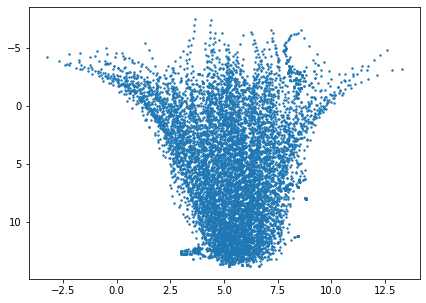

In [23]:
import matplotlib.pyplot as plt

def formatted_time(time_in_sec):
    m = time_in_sec//60
    s = time_in_sec%60
    return f"{m:.0f} min and {s:.0f} sec"

scene = 'eth'
directory = self.data_dirs[DATASET_NAME_TO_NUM[scene]]
file_path = os.path.join(directory, 'true_pos_.csv')
data = np.genfromtxt(file_path, delimiter=',')

frames = data[0,:]
pedestrians = data[1,:]
X = data[2,:]
Y = data[3,:]
skip = frames[frames != frames.min()].min() - frames.min()

print("Scene:", scene)
print(f"There are {len(set(pedestrians))} unique pedestrians")
print(f"There are {len(set(frames))} unique frames")
print(f"First frame is {frames.min()}, last frame is: {frames.max()}, skip is: {skip}")
print(f"Video approximate length: {formatted_time(frames.max()/25)}")


fig, ax = plt.subplots(figsize=(7, 5))
if scene in ['eth', 'hotel']:
    X, Y = Y, X
    fig.gca().invert_yaxis()
print(f"X dimension: {X.max() - X.min():.2f}")
print(f"Y dimension: {Y.max() - Y.min():.2f}")
_ = ax.scatter(X,Y,s=2)